# Using FastAI ULMFiT to complete your assignment


## 0. Setup

In [77]:
from fastai.text import *
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Import the data

In [78]:
# Loaded dataset and lables after creating the folder structure as shown below in Google
text_path = 'gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/title_StackOverflow.txt'
label_path = 'gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/label_StackOverflow.txt'

df_text = pd.read_csv(text_path, sep='\t', names=['text'], header=None)
df_label = pd.read_csv(label_path, sep='\t', names=['label'], header=None)

df = pd.concat([df_label, df_text], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [79]:
mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df['label'] = df['label'].map(mapping)

df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


## 2. Create train & validation datasets and FastAI data bunch

In [80]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3)

df_trn.shape, df_val.shape

((14000, 2), (6000, 2))

In [81]:
# Language model data - use TextLMDataBunch.from_df
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## 3. Create and Train the Language Model

In [82]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


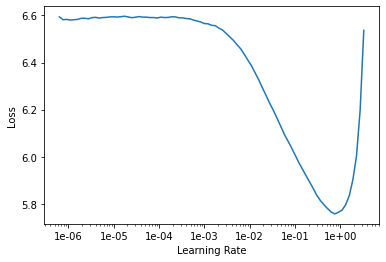

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.972229,4.199581,0.295956,00:07


In [86]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.177109,3.963669,0.325276,00:07


In [87]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.943291,3.886859,0.331696,00:08


In [88]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.812444,3.861748,0.334112,00:09
1,3.775379,3.852598,0.335360,00:09


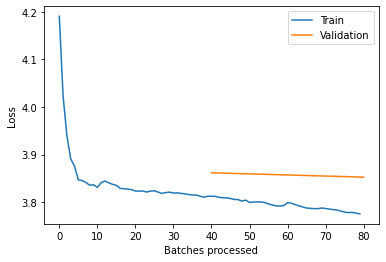

In [89]:
learn.recorder.plot_losses()

In [90]:
learn.show_results()

text,target,pred
xxbos xxmaj comparing xxmaj two xxmaj arrays . xxbos xxunk ) has no effect xxmaj qt xxbos where does drupal,store the actual content in the database ? xxbos xxmaj accessing a remote file with a sharepoint xxmaj web xxmaj,'s a xxunk xxunk of a xxmaj ? xxbos xxmaj how xxmaj xxmaj xxup from xxmaj xxmaj xxmaj server xxmaj
magento after install i ca n't access my xxunk and front view ? xxbos xxmaj problems xxunk deleted directory to,xxup svn repository xxbos xxmaj using xxmaj wordpress xxup loop with pages instead of posts ? xxbos xxmaj apache xxmaj,a svn xxbos xxbos xxmaj how xxmaj spring xxmaj api to xxmaj xxbos of xxmaj xxbos xxbos xxmaj how xxmaj
log for files committed by a particular user since a certain date ? xxbos xxmaj how to create a backup,of an xxup postgres xxup db using bash ? xxbos xxup svn best - xxunk - working in a team,file a xxmaj ajax in xxunk in xxmaj ? xxbos xxmaj linq : practices practices for xxmaj xxbos xxmaj xxmaj
xxup asp.net xxup ajax xxunk ( ) xxmaj javascript method xxbos xxmaj case - insensitive xxup xxunk in xxmaj cocoa,? xxbos xxmaj going from xxup php xxmaj xxunk to xxmaj java xxmaj hibernate xxbos xxmaj how can a cell,xxbos xxbos xxmaj how back xxmaj svn to xxunk to xxmaj xxunk xxbos xxunk xxbos xxmaj how to i xxmaj
"force you to mark fields as virtual , but nhibernate does ? xxbos xxmaj assigning figure size to a figure",with a given handle ( xxup matlab ) xxbos xxmaj guard is xxunk when it should not be . xxbos,in a xxmaj name xxbos ) xxunk ) xxbos xxmaj how xxmaj xxmaj in using is be be used xxbos


In [91]:
learn.save_encoder('language_learner_model_1')

In [92]:
model_path = os.path.join( "gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/language_learner_model_1" )

learn.export(model_path)

## 4. Using the Language Model to Train the Classifier

In [94]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()
learn.load_encoder('language_learner_model_1')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (14000 items)
x: TextList
xxbos xxmaj with bash , how can i pipe standard error into another process ?,xxbos xxmaj xxunk a xxmaj shipping xxmaj method - xxmaj what am i missing,xxbos xxmaj sending xxmaj excel to user through xxup asp.net,xxbos xxup vs2008 : xxmaj launching the executable for a project that is n't the active project in a solution,xxbos xxup linq to xxup sql
y: CategoryList
bash,magento,excel,visual-studio,linq
Path: .;

Valid: LabelList (6000 items)
x: TextList
xxbos xxmaj comparing xxmaj two xxmaj arrays .,xxbos xxunk ) has no effect xxmaj qt,xxbos where does drupal store the actual content in the database ?,xxbos xxmaj accessing a remote file with a sharepoint xxmaj web xxmaj part,xxbos xxmaj code xxmaj xxunk ( sort of ) : a xxmaj functional xxmaj xxunk
y: CategoryList
cocoa,qt,drupal,sharepoint,haskell
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embe

In [95]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.936633,1.388280,0.616667,00:07


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [96]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.040485,0.748960,0.789833,00:10


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non

In [97]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.728993,0.623629,0.819333,00:12


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non

In [98]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.637778,0.584090,0.831167,00:15
1,0.633590,0.573002,0.834833,00:15


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non

## 5. Analyzing our results

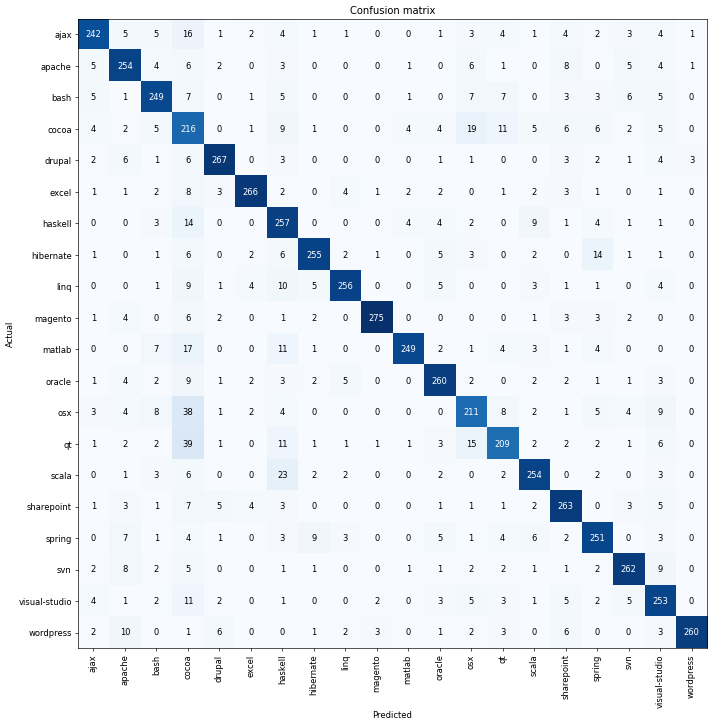

In [99]:
from fastai.train import ClassificationInterpretation
from fastai.vision import *
#preds, y, losses = learn.get_preds(with_loss = True)
#interp = ClassificationInterpretation(data_clas, preds, y, losses)

interpretation = ClassificationInterpretation.from_learner( learn )

interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

## 6. Predictions

In [100]:
df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


In [108]:
# predictions
x,y,z = learn.predict("How do I fill a DataSet or a DataTable from a LINQ query resultset ?")

x

Category tensor(8)

In [111]:
content = 'Best Subversion clients for Windows Vista (64bit)'

x, y, z = learn.predict(content)

print( f"prediction = {x}\n" )

prediction = svn



## 7. Export the model

In [106]:
model_path = os.path.join( "gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/text_classifier_learner_2" )

learn.export(model_path)